# Model-8

In [41]:
import tensorflow as tf
import numpy as np
from timeit import default_timer as timer
from dataset import Dataset
from layers import *
from networks import *
from model import Model
from dbase import DataBase
from visualisation import show_similarity

In [42]:
tr_data_path = "/netforge/datasets/private/roman/coins/2017-11-29/datasets/train/300_300_128_128_1_uint8_aug2.npy"
va_data_path = "/netforge/datasets/private/roman/coins/2017-11-29/datasets/valid/550_300_128_128_1_uint8_aug2.npy"

model_path   = "models/8/"

## Dataset

In [43]:
%%time
tr_dataset   = Dataset(tr_data_path)
va_dataset   = Dataset(va_data_path)
tr_dataset.load()
va_dataset.load()
image_shape  = list(tr_dataset.data.shape[-3:])
print("Train:", list(tr_dataset.data.shape), tr_dataset.data.dtype)
print("Valid:", list(va_dataset.data.shape), va_dataset.data.dtype)
print('-'*50)

Train: [300, 300, 128, 128, 1] uint8
Valid: [550, 300, 128, 128, 1] uint8
--------------------------------------------------
CPU times: user 8 ms, sys: 1.13 s, total: 1.14 s
Wall time: 1.12 s


## Build 

In [44]:
%%time
out_dims       = 300
margin         = .2
acc_batch_size = 100
network        = simple_conv

model = Model(image_shape, out_dims, acc_batch_size)
model.build(network)

CPU times: user 3.38 s, sys: 40 ms, total: 3.42 s
Wall time: 3.39 s


In [45]:
%%time
accs = []
for i in range(1):
    acc = model.calc_acc(tr_dataset)
    accs.append(acc)
acc = np.mean(accs)
print("Acc: %.1f%%" % (acc*100))

Acc: 26.0%
CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 52.3 ms


## Train

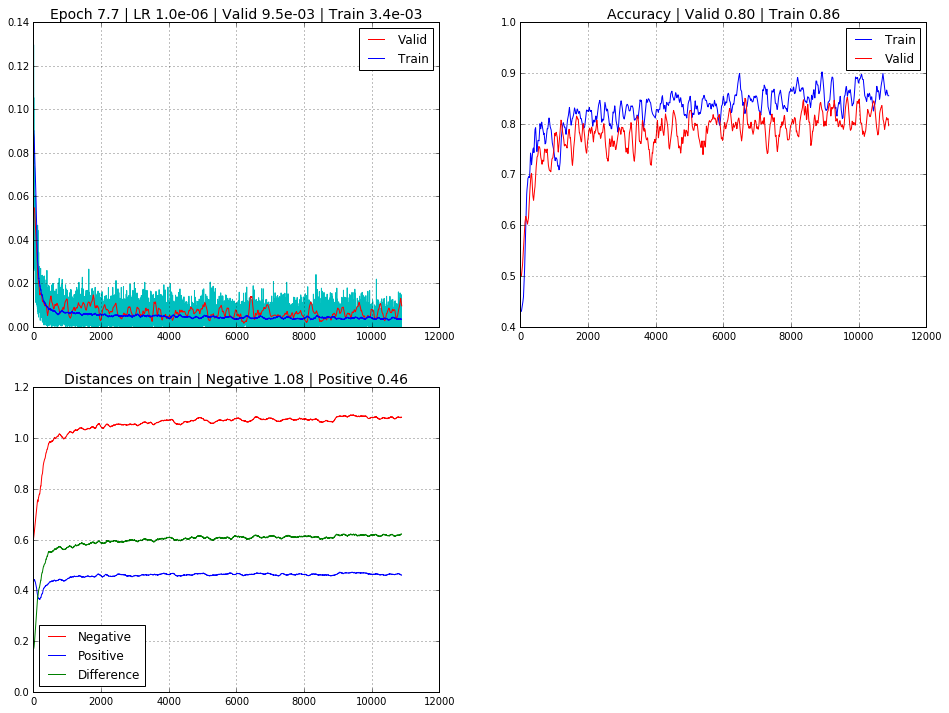

--------------------------------------------------
CPU times: user 3min 59s, sys: 1min 2s, total: 5min 1s
Wall time: 4min 30s


In [65]:
%%time
model.train(
    step_num   = 200000, 
    batch_size = 64,
    lr         = {1:1e-4, 0.02:3e-5, 0.01:1e-5, 7e-3:3e-6, 5e-3:1e-6, 3e-3:3e-7}, 
    log_every  = 30,
    tr_dataset = tr_dataset,
    va_dataset = va_dataset,
    margin     = margin,
    log_scale  = False)

model.save(model_path)
print('-'*50)

## Database

In [69]:
%%time
dataset   = tr_dataset # tr_dataset va_dataset
dbase     = DataBase()
ethalons  = dataset.get_ethalons()
augmented = dataset.get_augmented()
dbase.build(model, ethalons)
print("Ethalons :", list(ethalons.shape),  ethalons.dtype)
print("Augmented:", list(augmented.shape), augmented.dtype)
print('-'*50)

Ethalons : [300, 128, 128, 1] float32
Augmented: [300, 128, 128, 1] float32
--------------------------------------------------
CPU times: user 40 ms, sys: 12 ms, total: 52 ms
Wall time: 84.6 ms


## Accuracy

In [70]:
%%time
def accuracy(ind, k):
    assert 0 < k <= ind.shape[1]
    err = 0
    N   = len(ind)
    for i in range(N):
        ok = False
        for j in range(k):
            if i==ind[i,j]:
                ok = True
        err+= not ok
    return ((N-err)/N*100)

start = timer()
ind, dist = dbase.query(augmented, 3)
t = timer() - start
n = augmented.shape[0]

print("Database   : %s" % list(dbase.embeds.shape))
print("Request    : %s" % list(augmented.shape))
print("Performance: %.0f img/sec" % (n/t))
print('-'*50)
for k in range(1, ind.shape[1]+1):
    print("Accuracy@%d: %.1f%%" % (k, accuracy(ind, k)))
print('-'*50)

Database   : [300, 300]
Request    : [300, 128, 128, 1]
Performance: 3291 img/sec
--------------------------------------------------
Accuracy@1: 92.0%
Accuracy@2: 95.0%
Accuracy@3: 96.7%
--------------------------------------------------
CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 93.7 ms


## Search

Average distance: 0.42


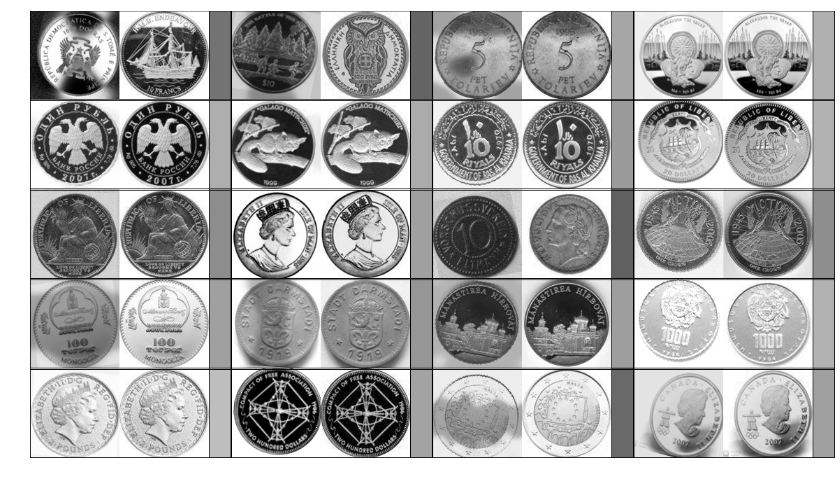

In [64]:
def search(request, max_k=0):
    ind, dist  = dbase.query(request, 3)
    per = np.random.choice(range(len(ind)), len(ind), replace=False)
    im1 = request[per]
    for k in range(0, max_k+1):
        print("Average distance: %.2f" % np.mean(dist[:,k]))
        im2 = dbase.images[ind[:,k]][per]
        sim = 1-dist[:,k][per]
        num = 20
        im1 = im1[:num]
        im2 = im2[:num]
        sim = sim[:num]
        show_similarity(im1, im2, sim, cols=4)

search(augmented)

## Restore

In [9]:
%time
model.restore(model_path)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs
INFO:tensorflow:Restoring parameters from models/8/
